In [2]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_deemph, center_deemph_r

from totoro.potentials import get_equivalent_galpy
from totoro.actions_staeckel import get_staeckel_aaf
from tqdm.notebook import tqdm, trange

In [10]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/allStarLite-r13-l33-58932beta.fits')
allstar_c = coord.SkyCoord(allstar['RA']*u.deg, allstar['DEC']*u.deg,
                           radial_velocity=allstar['VHELIO_AVG']*u.km/u.s)

In [8]:
vasiliev = at.QTable.read('/Users/apricewhelan/data/Misc/Vasiliev-globclust-new.fit')

c_vasiliev = coord.SkyCoord(vasiliev['_RAJ2000'], 
                            vasiliev['_DEJ2000'], 
                            distance=vasiliev['Dist'],
                            pm_ra_cosdec=vasiliev['pmRA'],
                            pm_dec=vasiliev['pmDE'],
                            radial_velocity=vasiliev['HRV'])

In [21]:
idx, sep, _ = allstar_c.match_to_catalog_sky(c_vasiliev)

In [24]:
sep_mask = sep < 0.5*u.deg
drv = allstar_c[sep_mask].radial_velocity - c_vasiliev.radial_velocity[idx[sep_mask]]

In [40]:
rv_mask = np.abs(drv) < 2*u.km/u.s
tmp = at.hstack((allstar[sep_mask][rv_mask], vasiliev[idx[sep_mask][rv_mask]]))

In [58]:
N = 0
Names = []
M_Hs = []
for name in np.unique(tmp['Name']):
    name_mask = tmp['Name'] == name
    mh_mask = (tmp['M_H'] > -3) & (tmp['VSCATTER'] < 1.)
    row_mask = name_mask & mh_mask
    
    if row_mask.sum() < 4:
        continue
    
    med_mh = np.median(tmp[row_mask]['M_H'])
    
    print(name, name_mask.sum(), f'{med_mh:.2f}')
    
    N += 1
    
    Names.append(name)
    M_Hs.append(med_mh)
    
print(N)

BH 229 7 -1.02
NGC 104 70 -0.70
NGC 1851 17 -1.07
NGC 1904 11 -1.49
NGC 2808 11 -1.04
NGC 288 30 -1.25
NGC 3201 79 -1.34
NGC 362 23 -1.09
NGC 4590 26 -2.12
NGC 5024 17 -1.86
NGC 5053 13 -2.11
NGC 5139 201 -1.58
NGC 5272 128 -1.39
NGC 5466 12 -1.85
NGC 5634 10 -0.17
NGC 5904 88 -1.18
NGC 6121 88 -1.01
NGC 6171 38 -0.94
NGC 6205 42 -1.43
NGC 6218 54 -1.24
NGC 6229 5 -1.24
NGC 6254 30 -1.48
NGC 6273 22 -1.71
NGC 6304 15 -0.45
NGC 6316 7 -0.69
NGC 6341 27 -2.12
NGC 6388 16 -0.47
NGC 6397 101 -1.89
NGC 6441 8 -0.43
NGC 6522 13 -0.47
NGC 6540 6 -0.14
NGC 6544 16 -1.42
NGC 6553 6 -0.16
NGC 6569 8 -0.95
NGC 6656 125 -1.61
NGC 6715 72 -0.58
NGC 6752 60 -1.39
NGC 6809 39 -1.72
NGC 6838 31 -0.72
NGC 7078 43 -2.21
NGC 7089 15 -1.40
Pal 5 7 -1.23
Terzan 5 4 0.37
Terzan 9 10 -0.31
44


In [61]:
joined = at.join(vasiliev, at.Table({'Name': Names, 'M_H': M_Hs}))
len(joined)

44

In [62]:
c = coord.SkyCoord(joined['_RAJ2000'], 
                   joined['_DEJ2000'], 
                   distance=joined['Dist'],
                   pm_ra_cosdec=joined['pmRA'],
                   pm_dec=joined['pmDE'],
                   radial_velocity=joined['HRV'])

In [63]:
galcen = c.transform_to(coord.Galactocentric())
galcen_mask = np.isfinite(galcen.x) & np.isfinite(galcen.v_x)

In [64]:
w0 = gd.PhaseSpacePosition(galcen.data[galcen_mask])
w0.shape

(44,)

In [65]:
mw = gp.MilkyWayPotential()

In [66]:
orbits = mw.integrate_orbit(w0, dt=-0.5, t1=0, t2=-6*u.Gyr)

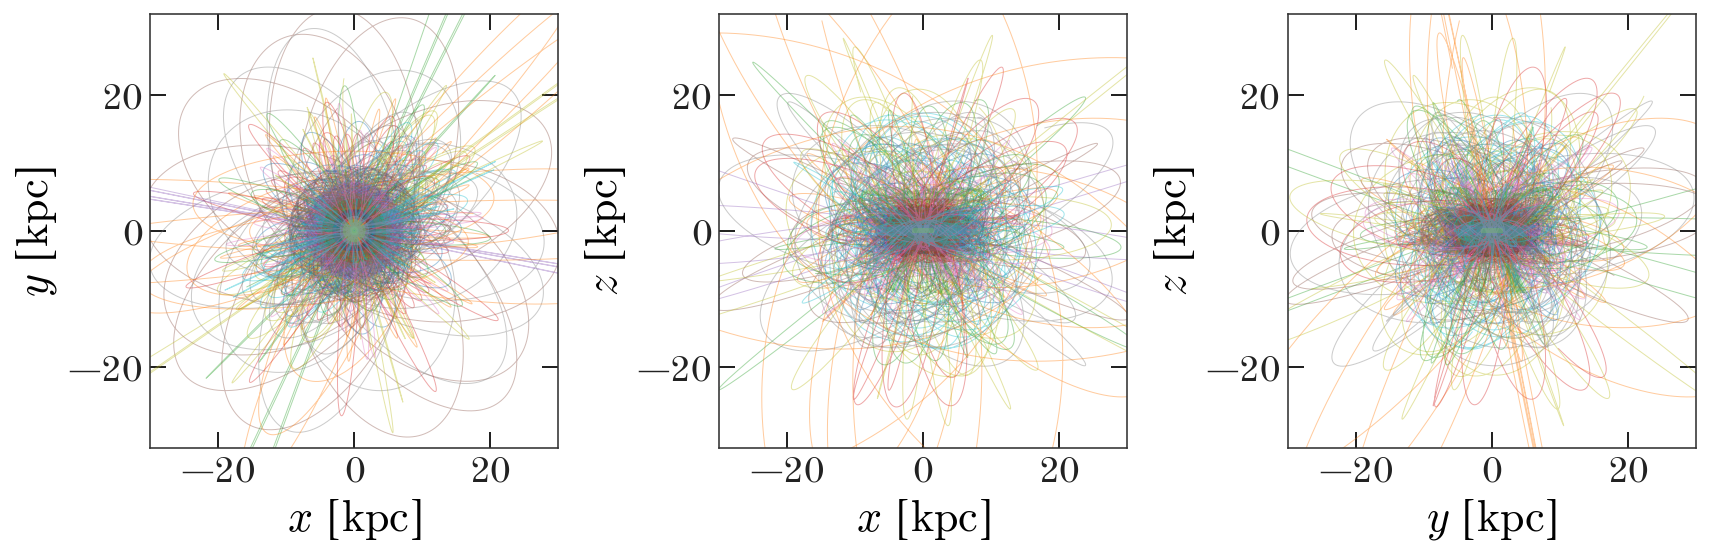

In [67]:
fig = orbits.plot(alpha=0.4, marker='', lw=0.5)
for ax in fig.axes:
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
fig.set_facecolor('w')

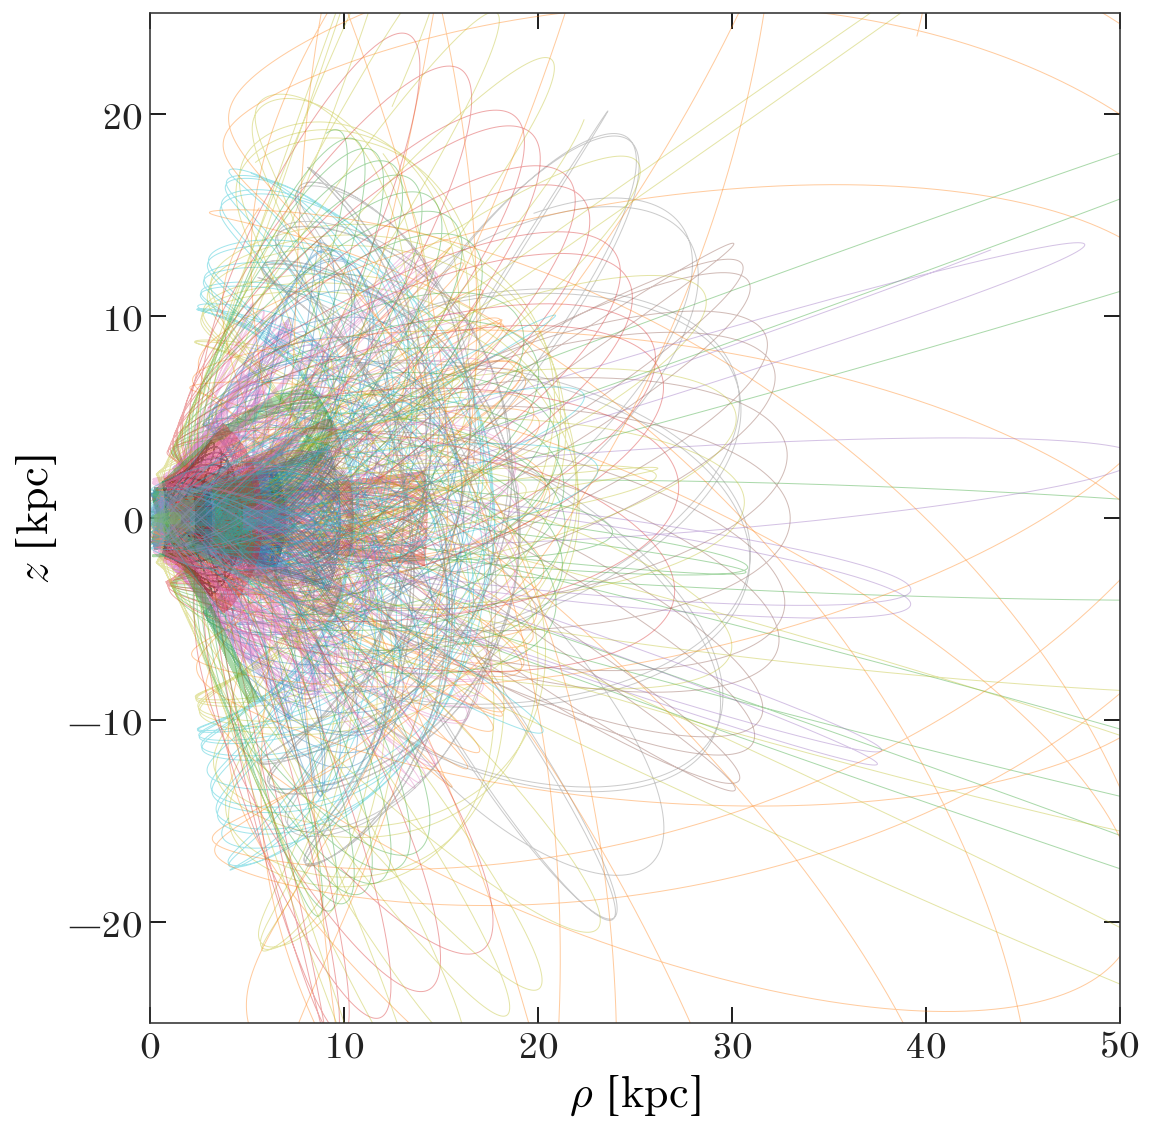

In [69]:
fig, axes = plt.subplots(figsize=(8, 8))
fig = orbits.cylindrical.plot(['rho', 'z'], alpha=0.4, marker='', lw=0.5,
                              axes=[axes])
for ax in fig.axes:
    ax.set_xlim(0, 50)
    ax.set_ylim(-25, 25)
fig.set_facecolor('w')

In [70]:
P = np.abs(orbits.estimate_period())
ecc = orbits.eccentricity(approximate=True)

In [88]:
aafs = {
    'actions': [],
    'angles': [],
    'freqs': []
}
for n in trange(w0.shape[0]):
    orbit_dop = mw.integrate_orbit(w0[n], dt=1., t1=0, t2=100 * P[n],
                                   Integrator=gi.DOPRI853Integrator)
    d = w0[n].spherical.distance.to_value(u.kpc)
    try:
        toy = gd.fit_isochrone(orbit_dop, m0=mw.mass_enclosed([d, 0, 0.]).value[0], 
                               minimize_kwargs=dict(method='powell'))
        aaf = gd.find_actions(orbit_dop, N_max=8, toy_potential=toy)
    except:
        for k in aafs.keys():
            aafs[k].append(np.full(3, np.nan) * aaf[k].unit)
        continue
    
    for k in aafs.keys():
        aafs[k].append(aaf[k])
        
for k in aafs:
    aafs[k] = u.Quantity(aafs[k])

/Users/apricewhelan/projects/gala/gala/dynamics/actionangle.py:538: UserWarning: More unknowns than equations!
  warnings.warn("More unknowns than equations!")

/Users/apricewhelan/projects/gala/gala/dynamics/actionangle.py:276: UserWarning: Need a longer integration window for mode [-3  2  6]
  warnings.warn("Need a longer integration window for mode {0}"

/Users/apricewhelan/projects/gala/gala/dynamics/actionangle.py:276: UserWarning: Need a longer integration window for mode [-3 -2  2]
  warnings.warn("Need a longer integration window for mode {0}"

/Users/apricewhelan/projects/gala/gala/dynamics/actionangle.py:276: UserWarning: Need a longer integration window for mode [-2 -4  6]
  warnings.warn("Need a longer integration window for mode {0}"

/Users/apricewhelan/projects/gala/gala/dynamics/actionangle.py:276: UserWarning: Need a longer integration window for mode [-2  0  2]
  warnings.warn("Need a longer integration window for mode {0}"

/Users/apricewhelan/projects/gala/gala/dyna

In [90]:
Jphi_unit = -229*u.km/u.s * 8.1*u.kpc
JR_unit = 25 * u.km/u.s * 1*u.kpc
Jz_unit = 15 * u.km/u.s * 0.5*u.kpc
J_units = [JR_unit, Jphi_unit, Jz_unit]
J_names = [r'J_R', r'J_\phi', r'J_z']

<ipython-input-93-a06e67d9199a>:4: RuntimeWarning: invalid value encountered in log10
  ax.plot(np.log10(aafs['actions'][:, i].to_value(J_unit)),



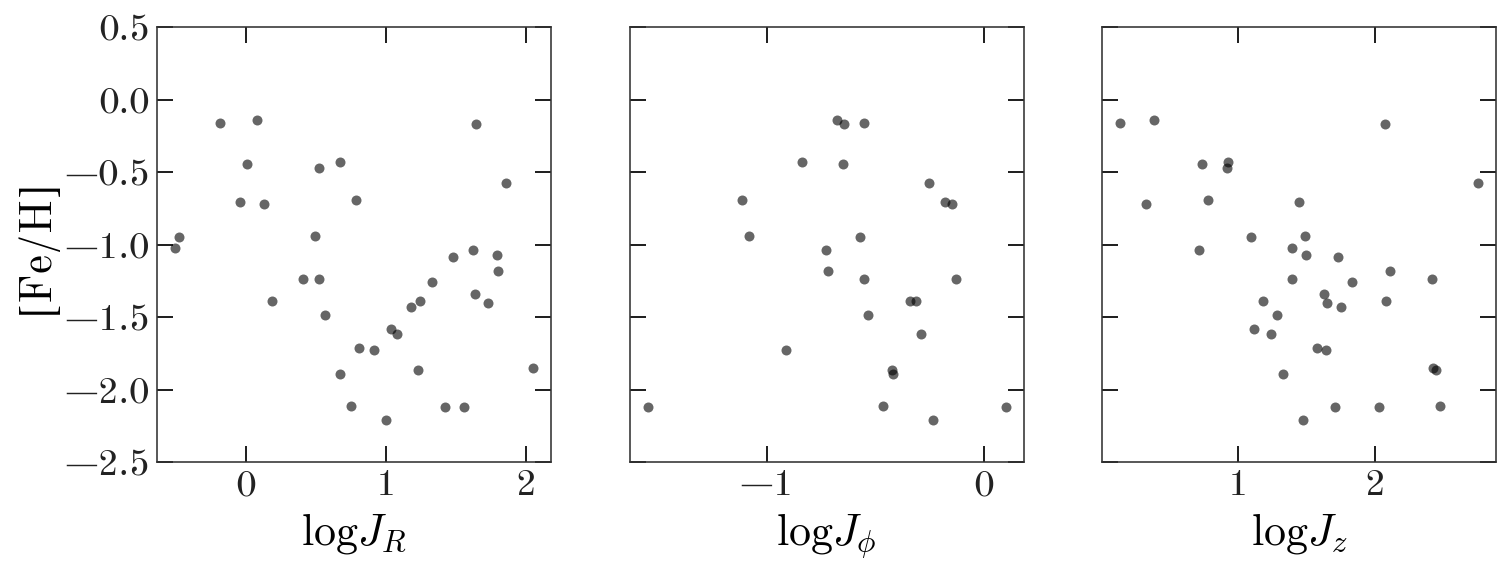

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, (ax, J_unit, name) in enumerate(zip(axes, J_units, J_names)):
    ax.plot(np.log10(aafs['actions'][:, i].to_value(J_unit)), 
            joined['M_H'],
            marker='o', mew=0, ls='none', alpha=0.6)
    ax.set_xlabel(rf'$\log{name}$')

axes[0].set_ylabel('[Fe/H]')
axes[0].set_ylim(-2.5, 0.5)

fig.set_facecolor('w')

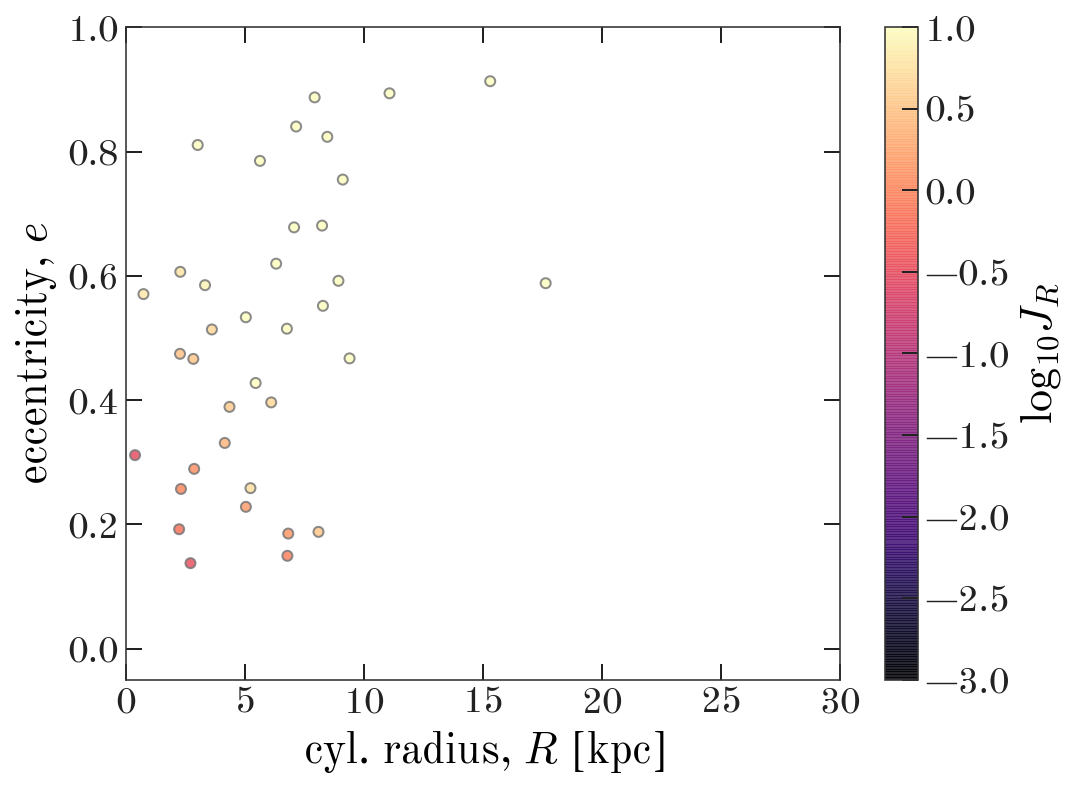

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.scatter(
    galcen.cylindrical.rho.to_value(u.kpc),
    ecc, 
    c=np.log10(aafs['actions'][:, 0].to_value(J_units[0])),
    alpha=0.85, vmin=-3, vmax=1, lw=1, edgecolor='#777777')

ax.set_xlabel('cyl. radius, $R$ [kpc]')
ax.set_ylabel('eccentricity, $e$')

ax.set_xlim(0, 30)
ax.set_ylim(-0.05, 1)

cb = fig.colorbar(cs)
cb.set_label(r'$\log_{\rm 10} J_R$')
fig.set_facecolor('w')

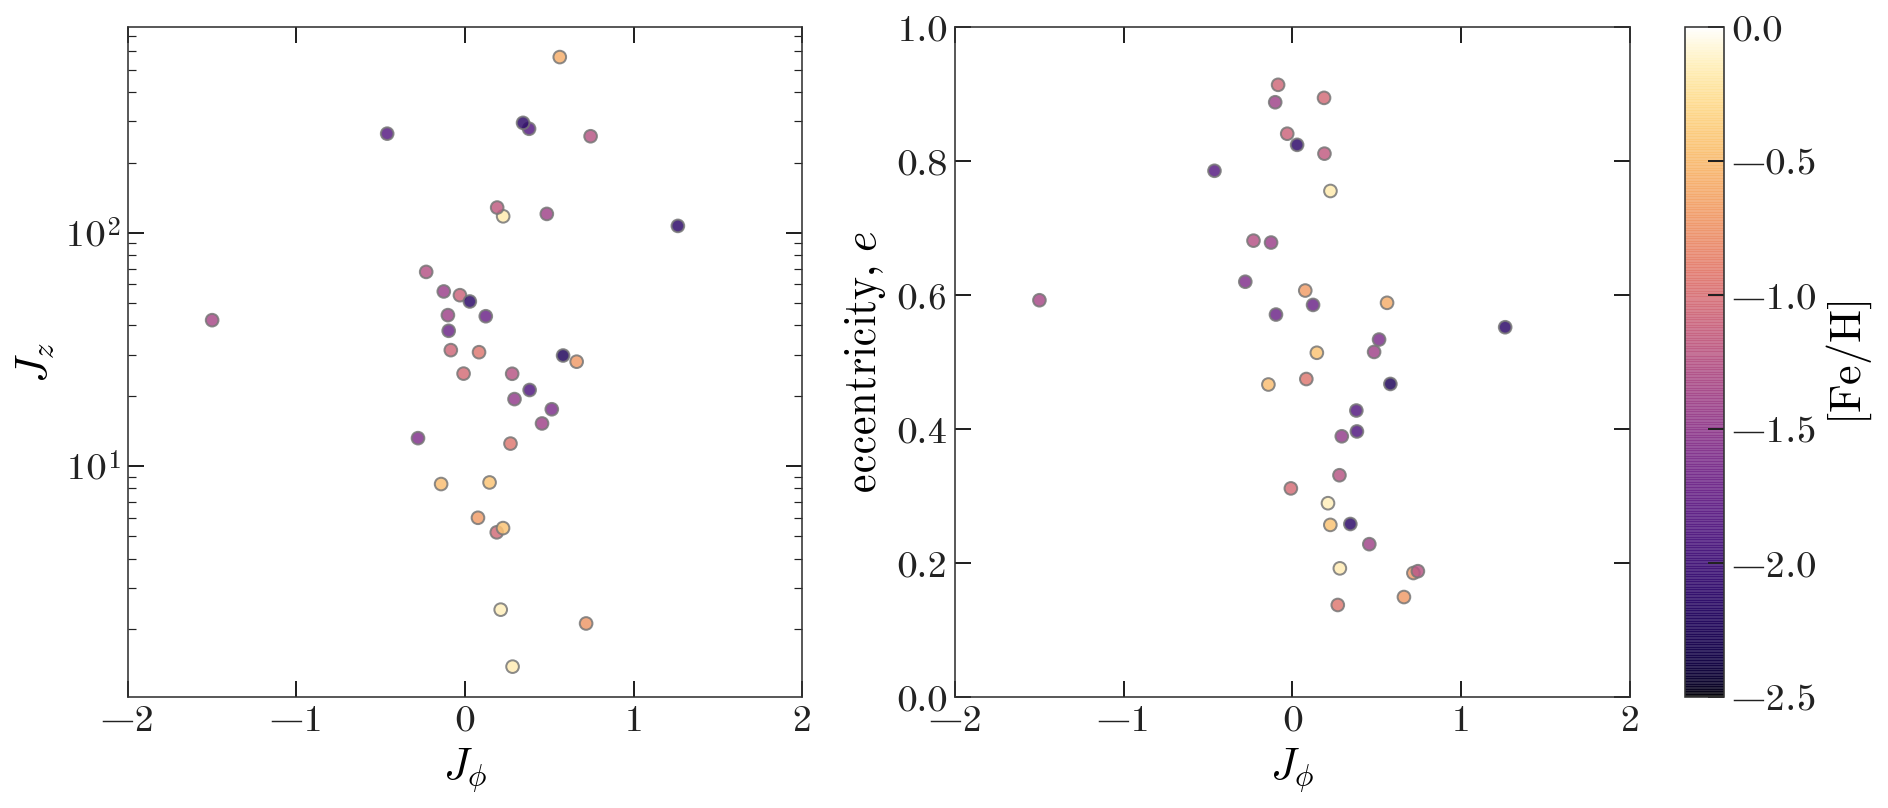

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5.5),
                         constrained_layout=True,
                         sharex=True)

ax = axes[0]
cs = ax.scatter(
    aafs['actions'][:, 1].to_value(J_units[1]),
    aafs['actions'][:, 2].to_value(J_units[2]),
    c=joined['M_H'],
    alpha=0.85, vmin=-2.5, vmax=0., 
    s=40, lw=1, edgecolor='#777777', cmap='hesperia')

ax.set_xlabel(r'$J_\phi$')
ax.set_ylabel('$J_z$')

ax.set_yscale('log')

ax = axes[1]
cs = ax.scatter(
    aafs['actions'][:, 1].to_value(J_units[1]),
    ecc,
    c=joined['M_H'],
    alpha=0.85, vmin=-2.5, vmax=0., 
    s=40, lw=1, edgecolor='#777777', cmap='hesperia')

ax.set_xlabel(r'$J_\phi$')
ax.set_ylabel('eccentricity, $e$')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 1)

cb = fig.colorbar(cs, ax=axes, aspect=40)
cb.set_label(r'$[{\rm Fe} / {\rm H}]$')

fig.set_facecolor('w')

In [104]:
from scipy.optimize import root

def obj(r, E):
    vcirc = mw.circular_velocity([r, 0, 0.]).to_value(u.km/u.s)[0]
    phi = mw.energy([r, 0, 0.]).to_value((u.km/u.s)**2)[0]
    return E - (0.5*vcirc**2 + phi)

In [146]:
tmp = {
    'Rcirc': [],
    'vcirc': [],
    'Lcirc': [],
    'Lcirc2': [],
}
for n in trange(w0.shape[0]):
    E = w0[n].energy(mw).to_value((u.km/u.s)**2)[0]
    res = root(obj, x0=w0[n].spherical.distance.value, args=(E, ))
    if not res.success:
        print(f"FAILED {n}")
        Rcirc = np.nan
        vcirc = np.nan
        Lcirc = np.nan
        Lcirc2 = np.nan
        continue
    
    else:
        Rcirc = res.x[0]
        vcirc = mw.circular_velocity([Rcirc, 0, 0]).to_value(u.km/u.s)[0]
        Lcirc = Rcirc * vcirc
        
        phi = mw.energy(w0[n]).to_value((u.km/u.s)**2)[0]
        r = w0[n].spherical.distance.to_value(u.kpc)
        Lcirc = np.sqrt((E - phi) * 2 * r**2)
    
    tmp['Rcirc'].append(Rcirc * u.kpc)
    tmp['vcirc'].append(vcirc * u.km/u.s)
    tmp['Lcirc'].append(Lcirc * u.kpc * u.km/u.s)
    tmp['Lcirc2'].append(Lcirc2 * u.kpc * u.km/u.s)
    
for k in tmp:
    tmp[k] = u.Quantity(tmp[k])
tmp = at.Table(tmp)

In [147]:
# eta = (-aafs['actions'][:, 1] / tmp['Lcirc']).decompose()
# xsi = ((aafs['actions'][:, 2] - aafs['actions'][:, 0]) / tmp['Lcirc']).decompose()

eta = (-aafs['actions'][:, 1] / tmp['Lcirc2']).decompose()
xsi = ((aafs['actions'][:, 2] - aafs['actions'][:, 0]) / tmp['Lcirc2']).decompose()

In [159]:
inner_mask = w0.spherical.distance < 10*u.kpc
outer_mask = w0.spherical.distance >= 10*u.kpc

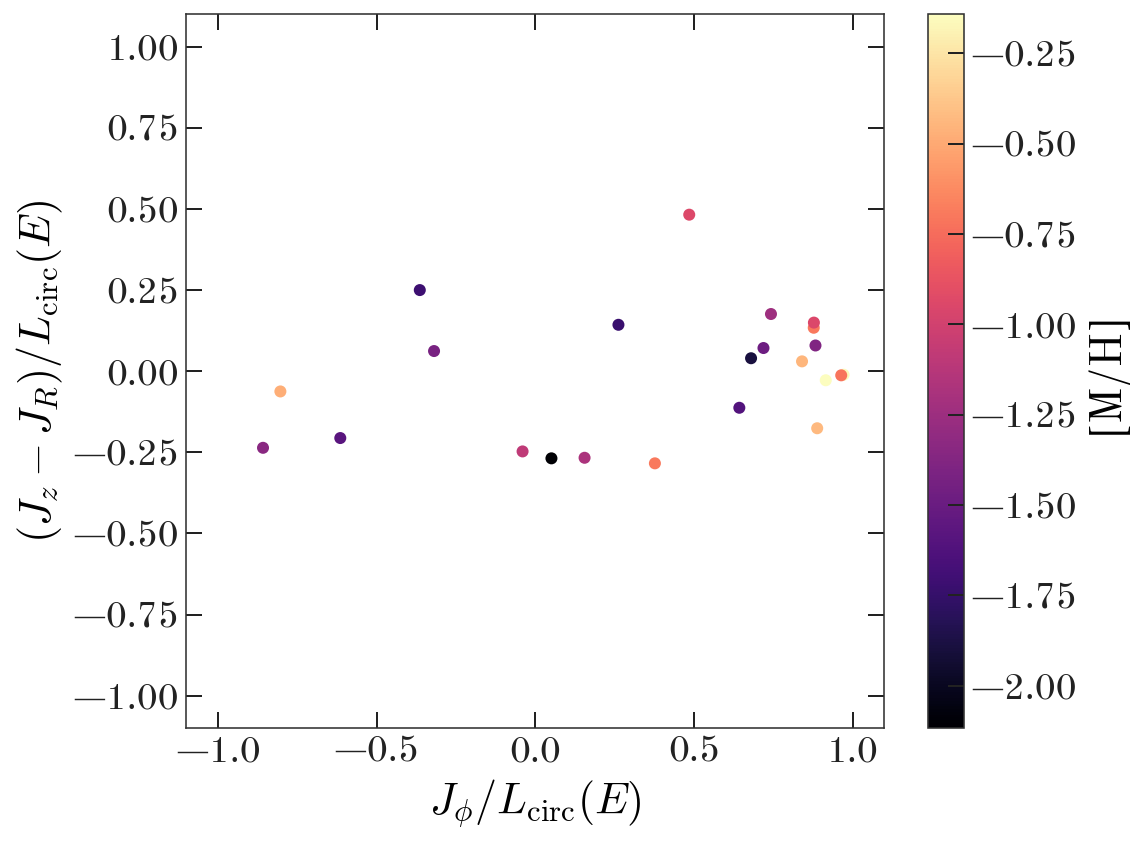

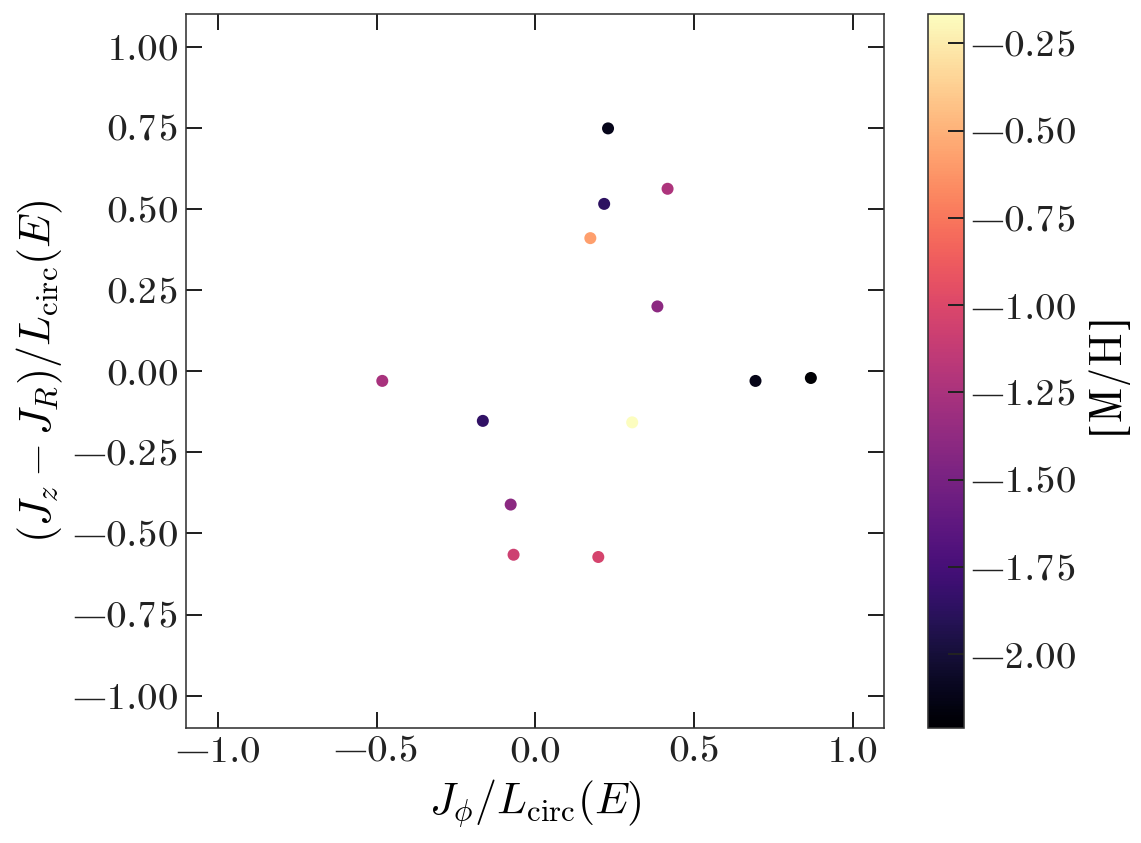

In [160]:
for mask in [inner_mask, outer_mask]:
    fig, ax = plt.subplots(figsize=(8, 6))
    cs = ax.scatter(eta[mask], xsi[mask], c=joined['M_H'][mask])
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    ax.set_xlabel(r'$J_\phi / L_{\rm circ}(E)$')
    ax.set_ylabel(r'$(J_z-J_R) / L_{\rm circ}(E)$')

    cb = fig.colorbar(cs)
    cb.set_label('[M/H]')

    fig.tight_layout()
    fig.set_facecolor('w')